# Quuantum Teleportation

このノートブックは、量子テレポーテーションを示しています。最初にQiskitの組み込みシミュレーターを使用して、量子回路をテストし、次に実際の量子コンピュータで試してみます。

## 1. Overview

アリスはボブに量子情報を送信したいと考えています。具体的には、彼女がqubit状態 |ψ> = α|0> + β|1>を送信したいとします。これにはαとβに関する情報をボブに渡す必要があります。

未知の量子状態の正確なコピーを単純に作成することはできないという量子力学の定理が存在します。これは、"no-cloning theorem(非クローニング定理)"として知られています。この結果、アリスは|ψ>のコピーを生成してボブに渡すことができないことがわかります。コピーできるのは古典的な状態のみです。(重ね合わせは不可)

ただし、2つの古典的なbitと、もつれたqubitのペアを利用することにより、アリスは自分の状態|ψ>をボブに転送することができます。私たちはこのテレポートを、最後にボブが持つことになると呼び、アリスの手元にはもうありません。

## 2. The Quantum Teleportation Protocol

qubitを転送するには、アリスとボブはサードパーティ(イブ)を使用して、絡み合ったqubitのペアを送信する必要があります。アリスは、qubitに対して幾つかの操作を実行し、その結果を従来の通信チャネルを介してボブに送信し、ボブは、アリスのqubitを受信するために自分の側で幾つかの操作を実行します。

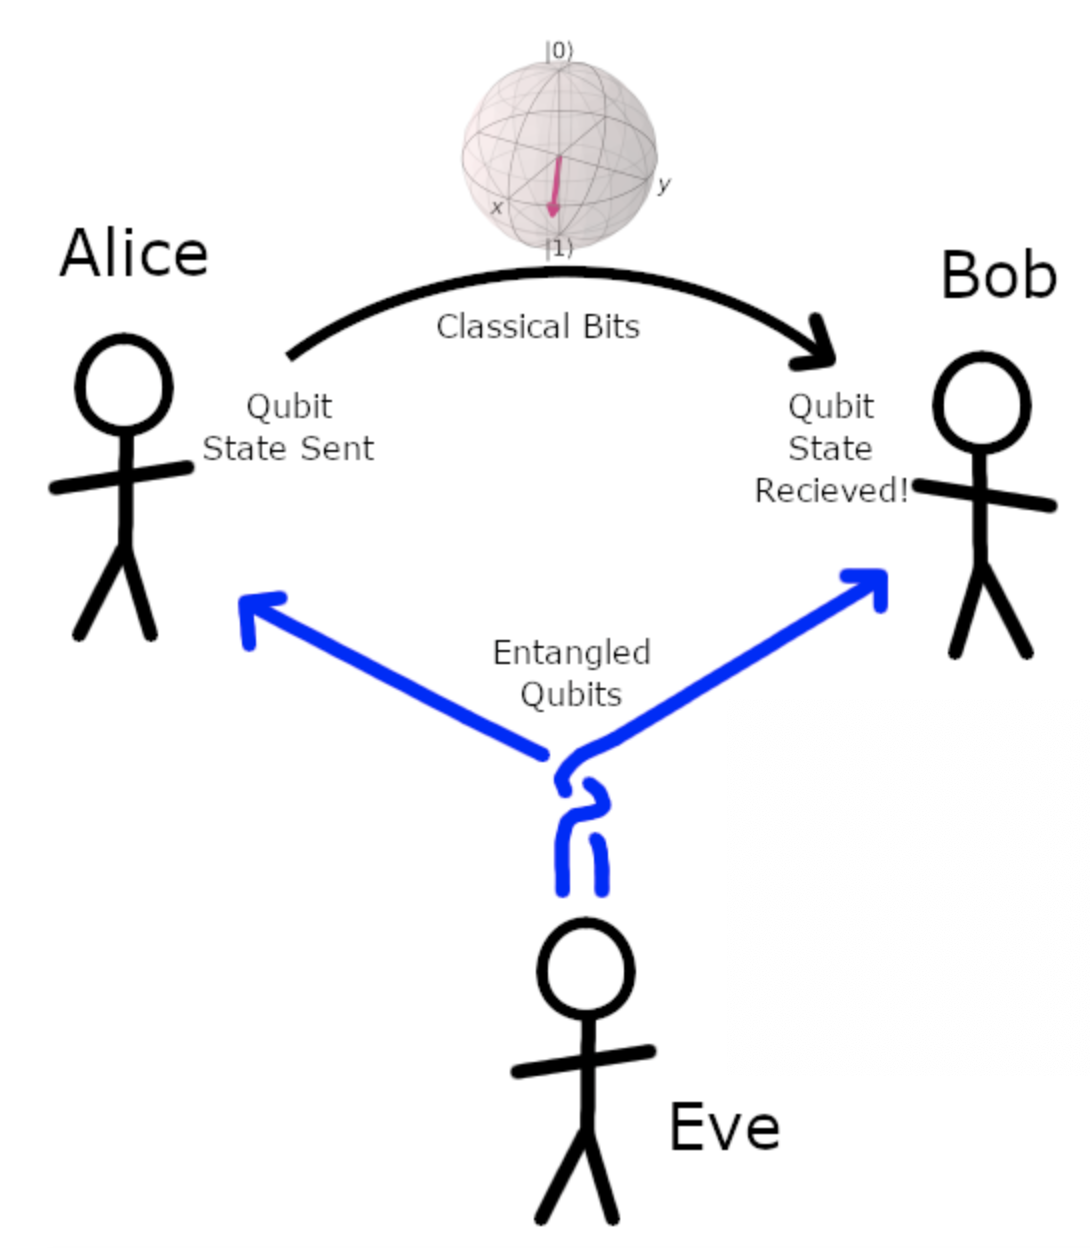

以下に量子回路の手順を説明します。ここでは、実際に「送信」されるqubitはありません。その部分は想像するだけです！

まずは、セッションをセットアップします。

In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize

そして、量子回路を作成しましょう。

In [2]:
qr = QuantumRegister(3)    # Protocol uses 3 qubits
crz = ClassicalRegister(1) # and 2 classical bits
crx = ClassicalRegister(1) # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

### Step 1

サードパーティーのイブは、絡み合ったqubitのペアを作成し、1つをボブに、もう1つをアリスに与えます。

イブが作成するペアは、"Bell pair(ベルペア)"と呼ばれる特別なペアです。量子回路言語では、2つのqubit間でベルペアを作成する方法は、アダマールゲートを使用して、それらの1つをX基底(|+>および|->)に最初に転送し、次にCNOTゲートをX基底のqubitに制御されているqubitに適用します。

In [3]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

In [4]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Eve entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q1_0: ──────────
      ┌───┐     
q1_1: ┤ H ├──■──
      └───┘┌─┴─┐
q1_2: ─────┤ X ├
           └───┘
c2_0: ══════════
                
c3_0: ══════════

2人に配られた時、アリスが所有したのがqi、ボブが所有したのをq2とします。

### Step 2

In [5]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [6]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
q2_0: ───────────░───■──┤ H ├
      ┌───┐      ░ ┌─┴─┐└───┘
q2_1: ┤ H ├──■───░─┤ X ├─────
      └───┘┌─┴─┐ ░ └───┘     
q2_2: ─────┤ X ├─░───────────
           └───┘ ░           
c4_0: ═══════════════════════
                             
c5_0: ═══════════════════════

### Step 3

次に、アリスは自分が所有する両方のqubit、q1と|ψ>に測定値を適用し、この結果を古典的なbitに格納します。次に、これらの2bitをボブに送信します。

In [7]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

In [8]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
q3_0: ───────────░───■──┤ H ├─░─┤M├───
      ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
q3_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
      └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
q3_2: ─────┤ X ├─░────────────░──╫──╫─
           └───┘ ░            ░  ║  ║ 
c6_0: ═══════════════════════════╩══╬═
                                    ║ 
c7_0: ══════════════════════════════╩═

### Step 4

既にqubit q2を持っているボブは、古典的なビットの状態に応じて次のゲートを適用します。

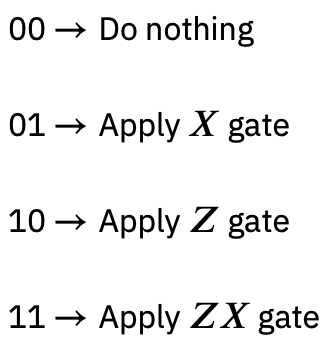

(この情報の転送は純粋に古典的なものであることに注意してください。)

In [9]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

In [10]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3)
crz, crx = ClassicalRegister(1), ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
q4_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
      ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
q4_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
      └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
q4_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
           └───┘ ░            ░  ║  ║  ░  └─┬─┘  └─┬─┘ 
                                 ║  ║       │   ┌──┴──┐
c8_0: ═══════════════════════════╩══╬═══════╪═══╡ = 1 ╞
                                    ║    ┌──┴──┐└─────┘
c9_0: ══════════════════════════════╩════╡ = 1 ╞═══════
                                         └─────┘

そして出来上がり！このプロトコルの終わりに、アリスのqubitはボブの元にテレポートしました。

## 3. Simulating the Teleportation Protocol

### 3.1 How Will We Test the Protocol on a Quaantum Computer?

このノートでは、ランダムな状態(|ψ>)でアリスのqubitを初期化します。この状態は|90>の初期化ゲートを使用して作成されます。この章では、関数"random_state"を使用してψを選択しますが、ψを任意のqubit状態に自由に設定できます。

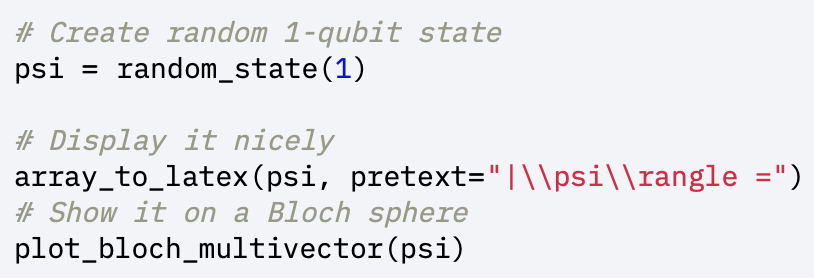

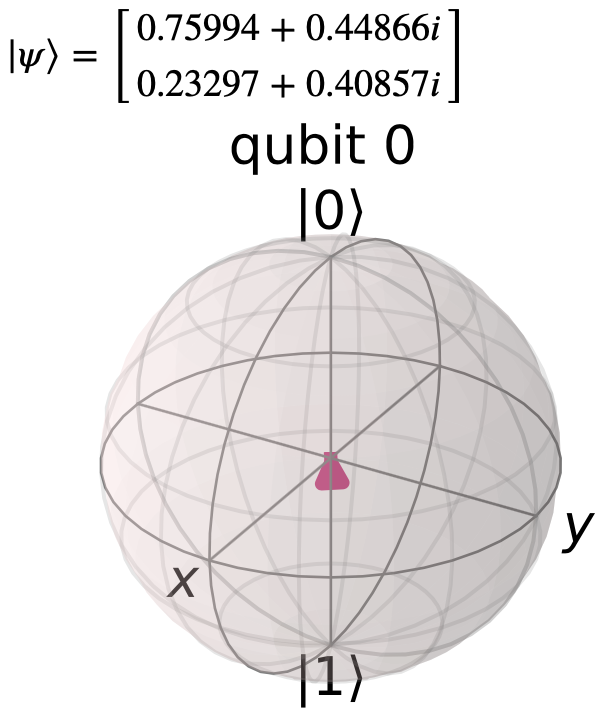

|0>から|ψ>を作成するための初期化ゲートを作成しましょう。

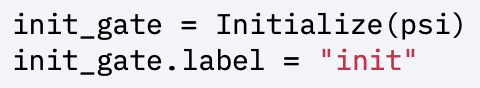

量子テレポーテーション回路が機能している場合、回路の最後でqubit|q2>はこの状態になります。これは、statevectorシミュレーターを使用して確認します。

### 3.2 Using the Statevector Simulator

statevectorシミュレーターを使用して、qubitがテレポートされたことを確認できます。

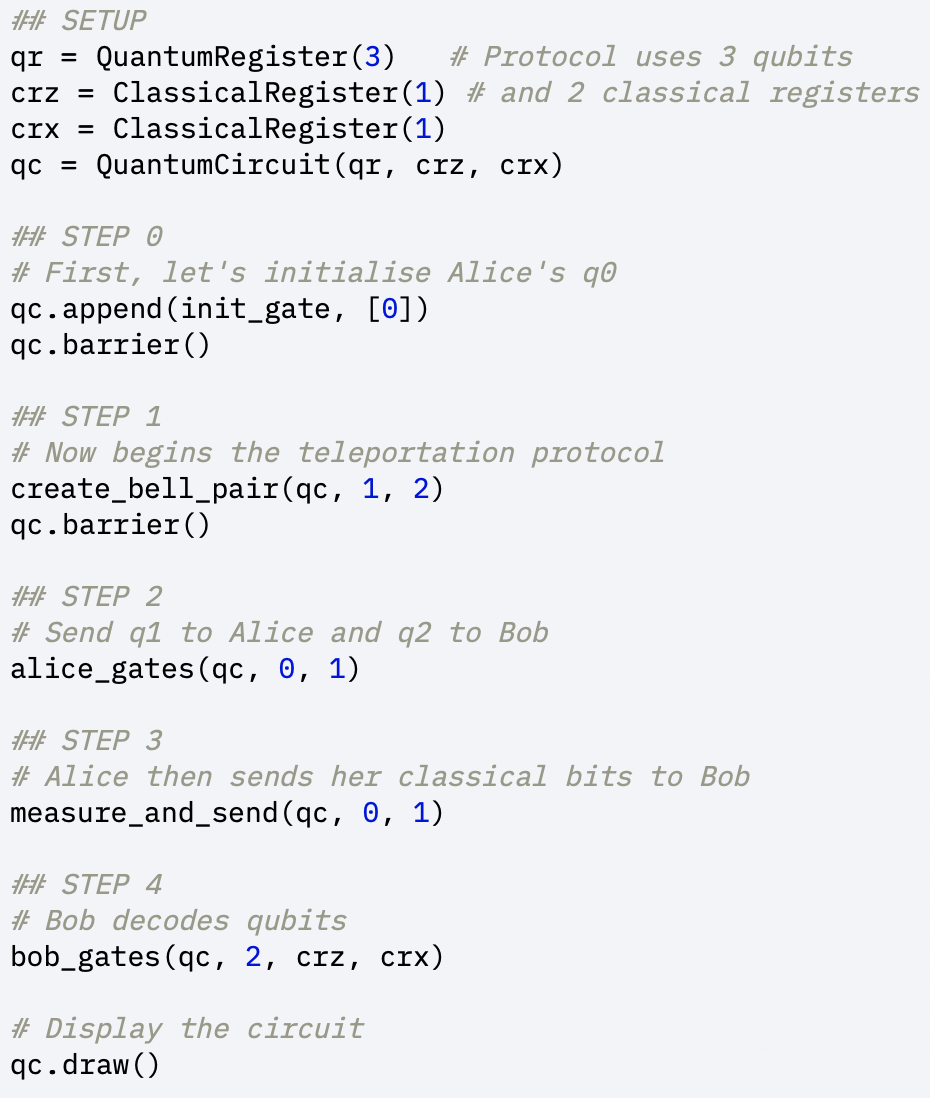

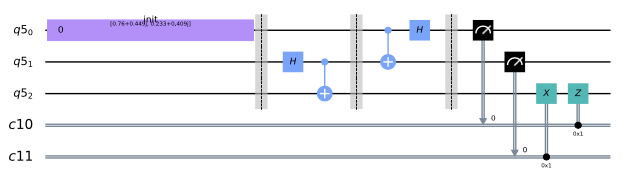

執筆時点では、上の画像の初期化ゲートにレンダリングの問題がありますが、回路は問題なく動作します。状態ベクトルシミュレータを使用すると、|q2>の状態で作成した状態|ψ>と同じであり、|q0>と|q1>の状態は|0>または|1>。状態|ψ>がqubit0からqubit2にテレポートされました。

In [11]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

NameError: name 'qc' is not defined

確認するために、このセルを数回実行できます。qubit0と1は状態を変更しますが、qubit2は常に状態|ψ>にあることに気づくでしょう。

### 3.3 Using the QASM Simulator

量子テレポーテーションは、2つのパーティ間でqubitを送信するように設計されています。これを実証するためのハードウェアはありませんが、ゲートが単一の量子チップ上で正しい変換を実行することを実証できます。ここでは、QASMシミュレーターを使用して、プロトコルをテストする方法をシミュレートします。

実際の量子コンピュータでは、状態ベクトルをサンプリングできないため、テレポーテーション回路が機能していることを確認したい場合は、少し異なる方法で行う必要があります。|0>qubitを状態|ψ>に変換するために初期化を使用したことを思い出してください。

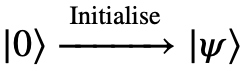

全ての量子ゲートは可逆的であるため、次を使用して初期化のインバースを見つけることができます。

inverse_init_gate = init_gate.gates_to_uncompute()

この操作には、次にプロパティがあります。

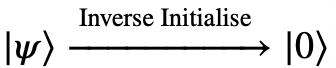

qubit|q0>が|q2<にテレポートされたことを証明するために、|q2>でこの逆初期化を行うと、|0>を確実に測定することが期待されます。以下の回路でこれを行います。

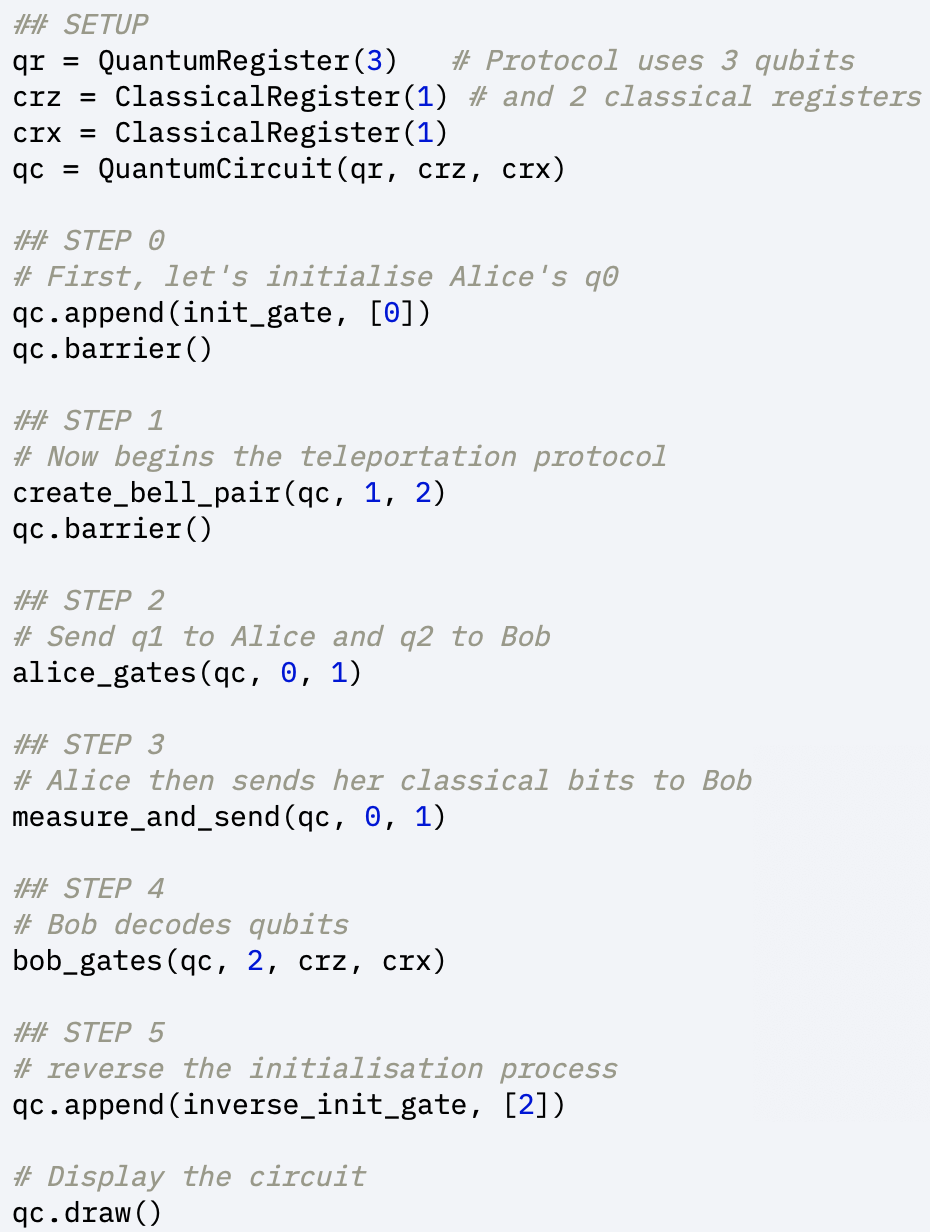

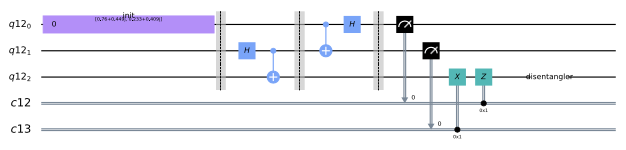

この場合も、inverse_init_gate(回路図では"disentangler"と呼ばれます)にはレンダリングの問題がありますが、画像にゲートが表示されていることがはっきりとわかります。最後に、3番目のqubitを測定し、その結果を3番目の古典的なbitに格納します。

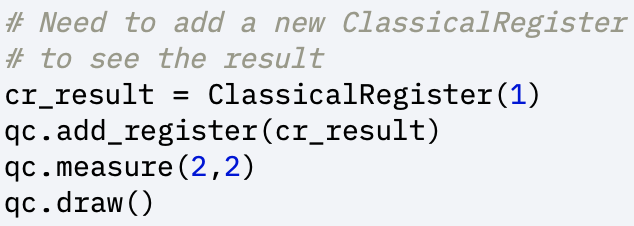

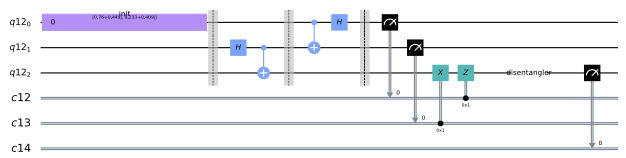

そして、実験を実行します。

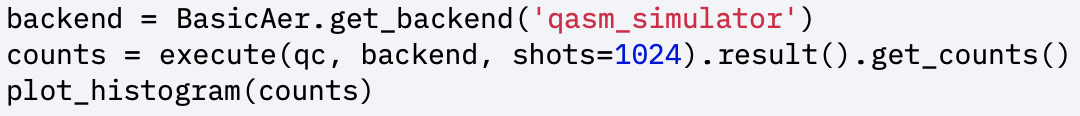

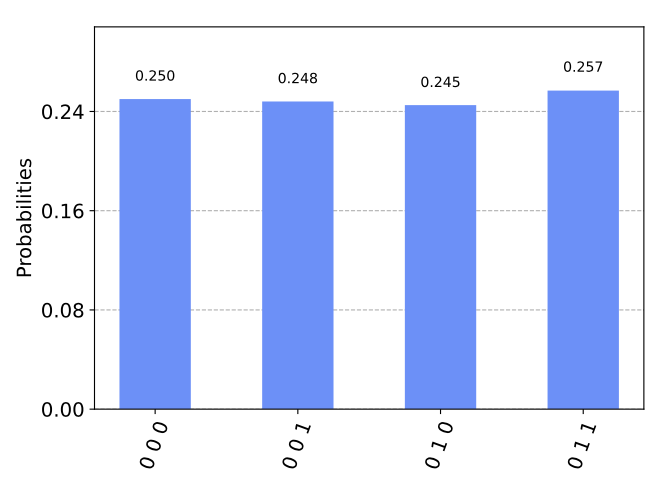

|0>の状態でq2(文字列の左端のbit)を測定する可能性が100%あることがわかります。これは予想される結果であり、テレポーテーションプロトコルが適切に機能していることを示しています。

## 4. Teleportation on a Real Quantum Computer

### 4.1 IBM hardware and Deferred Measurement

IBM量子コンピュータは現在、測定後の指示はサポートしていません。つまり、実際のハードウェアで現在の形式で量子テレポーテーションを実行することはできません。幸いなことに、これは遅延測定原理により、計算を実行する能力を制限しません。原則は、全ての測定を回路の最後まで延期できること、つまり全ての測定を最後まで移動でき、同じ結果が表示されることを示しています。

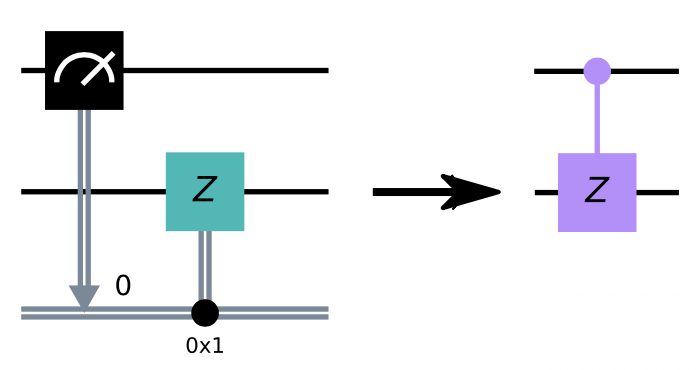

早期測定のメリットはハードウェアに関連しています。早期に測定できれば、qubitを再利用できたり、qubitが壊れやすい重ね合わせにある時間を短縮したりできる場合があります。この例では、量子テレポーテーションの初期の測定により、直接量子通信チャネルなしでqubit状態を送信できました。

ゲートを移動すると、実際のハードウェアで、"テレポーテーション"回路をデモンストレーションできますが、テレポーテーションプロセス(従来のチャネルを介した上司状態の転送)の利点が失われることに注意してください。

bob_gates関数をnew_bob_gatesに書き換えます。

In [ ]:
def new_bob_gates(qc, a, b, c):
    qc.cz(a, c)
    qc.cx(b, c)

そして、新たな回路を作ります。

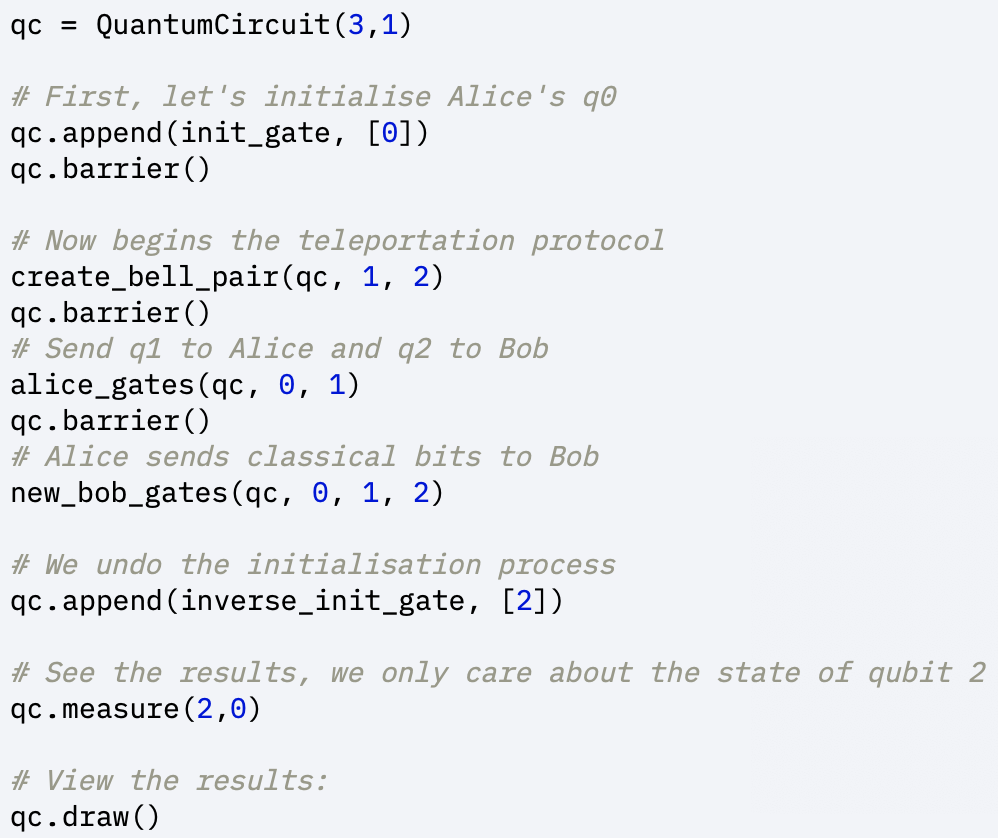

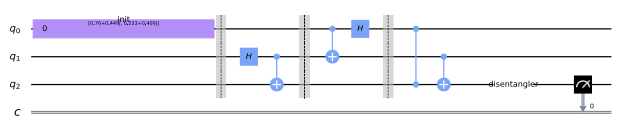

### 4.2 Executing

In [ ]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

In [ ]:
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
job_exp = execute(qc, backend=backend, shots=8192)

In [ ]:
# Get the results and display them
exp_result = job_exp.result()
exp_measurement_result = exp_result.get_counts(qc)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

ここでわかるように、|1>を測定した結果がいくつかあります。これらは、ゲートとqubitのエラーが原因で発生します。対照的に、ノートブックの初期の部分にある私たちのシミュレーターは、ゲートにエラーがなく、エラーのないテレポーテーションを可能にしました。

In [ ]:
error_rate_percent = sum([exp_measurement_result[result] for result in exp_measurement_result.keys() if result[0]=='1']) \
                    * 100./ sum(list(exp_measurement_result.values()))
print("The experimental error rate : ", error_rate_percent, "%")